In [1]:
import os
import sys
import numpy as np
import pandas as pd
import pickle

# set warnings
import warnings
warnings.simplefilter(action='ignore', category = Warning)

# add parent folder path to the namespace
sys.path.append(os.path.dirname(os.getcwd()))

# import modules and components
from utils.model_assets import Inference
from utils.validation_assets import BaselineModels, ModelValidation
import utils.global_paths as globpt
import configurations as cnf

# specify relative paths from global paths and create subfolders
cp_path = os.path.join(globpt.train_path, 'checkpoints')
res_path = os.path.join(globpt.data_path, 'analysis')
os.mkdir(cp_path) if not os.path.exists(cp_path) else None
os.mkdir(res_path) if not os.path.exists(res_path) else None

# Load data and model

Load the pretrained model from training/checkpoints. Preprocessed data is loaded and use to benchmark baseline model for their accuracy in predicting next roulette extractions. The data is extracted according to the selected type of pretrained model

In [2]:
# Load model
inference = Inference(cnf.seed) 
model, parameters = inference.load_pretrained_model(cp_path)
model_folder = inference.folder_path
model.summary(expand_nested=True)

# Load normalizer and encoders
pp_path = os.path.join(model_folder, 'preprocessing')
if parameters['model_name']=='CCM':    
    encoder_path = os.path.join(pp_path, 'categorical_encoder.pkl')
    with open(encoder_path, 'rb') as file:
        encoder = pickle.load(file)    

# load npy files
if parameters['model_name']=='CCM':
    pp_path = os.path.join(model_folder, 'preprocessing')
    X_train = np.load(os.path.join(pp_path, 'train_data.npy'))
    Y_train_OHE = np.load(os.path.join(pp_path, 'train_labels.npy'))
    X_test = np.load(os.path.join(pp_path, 'test_data.npy'))
    Y_test_OHE = np.load(os.path.join(pp_path, 'test_labels.npy'))
    train_inputs, train_outputs = X_train, Y_train_OHE
    test_inputs, test_outputs = X_test, Y_test_OHE
elif parameters['model_name']=='NMM':
    pp_path = os.path.join(model_folder, 'preprocessing')
    X_train_ext = np.load(os.path.join(pp_path, 'train_extractions.npy'))
    X_train_pos = np.load(os.path.join(pp_path, 'train_positions.npy'))
    Y_train_OHE = np.load(os.path.join(pp_path, 'train_labels.npy'))
    X_test_ext = np.load(os.path.join(pp_path, 'test_extractions.npy'))
    X_test_pos = np.load(os.path.join(pp_path, 'test_positions.npy'))
    Y_test_OHE = np.load(os.path.join(pp_path, 'test_labels.npy'))
    train_inputs, train_outputs = [X_train_ext, X_train_pos], Y_train_OHE
    test_inputs, test_outputs = [X_test_ext, X_test_pos], Y_test_OHE

Please select a pretrained model:

1 - FAIRSCCM_20240321H2321
2 - FAIRSNMM_20240321H2325


Model: "CCM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 positional_embedding (Posit  (None, 30, 1, 128)       4224      
 ionalEmbedding)                                                 
                                                                 
 reshape (Reshape)           (None, 30, 128)           0         
                                                                 
 transformer_encoder (Transf  (None, 30, 512)          1118080   
 ormerEncoder)                                                   
                                                                 
 conv_feed_forward (ConvFeed  (None, 30, 512)          1640832   
 Forward)                             

# Model evaluation

## 1. Baseline models

In [3]:
baseline = BaselineModels()
if parameters['model_name']=='NMM':
    X_train = np.concatenate((X_train_ext, X_train_pos), axis=1)
    X_test = np.concatenate((X_test_ext, X_test_pos), axis=1)

if parameters['inverted_test'] == False:
    train_idx = [x for x in range(len(X_train))]
    test_idx = [x + len(train_idx) for x in range(len(X_test))]
else:
    test_idx = [x for x in range(len(X_test))]
    train_idx = [x + len(test_idx) for x in range(len(X_train))]    

train_data = (X_train.squeeze(), Y_train_OHE)
test_data = (X_test.squeeze(), Y_test_OHE)

### 1.1 Decision Tree and Random Forest classifier

Use decision tree and random forest classifiers on the train and test dataset. Calculate accuracy score to compare with the FAIRS deep learning models

In [4]:
estimators = 100
DT_model = baseline.DecisionTree_classifier(train_data, seed=cnf.seed)
RFC_model = baseline.RandomForest_classifier(train_data, estimators=estimators, seed=cnf.seed)
DT_train_acc, DT_test_acc = baseline.model_accuracy(DT_model, train_data, test_data)
RFC_train_acc, RFC_test_acc = baseline.model_accuracy(RFC_model, train_data, test_data)

# print accuracy report
print('\nDecision Tree baseline model')
print(f'Train accuracy: {DT_train_acc}')
print(f'Test accuracy: {DT_test_acc}')
print(f'\nRandom Forest baseline model (estimators = {estimators})')
print(f'Train accuracy: {RFC_train_acc}')
print(f'Test accuracy: {RFC_test_acc}')

# generate predictions to compare them to real labels
validator = ModelValidation()
train_predictions = DT_model.predict(X_train.squeeze())
test_predictions = DT_model.predict(X_test.squeeze())
train_predictions = np.argmax(train_predictions, axis=1)
test_predictions = np.argmax(test_predictions, axis=1)
Y_train = np.argmax(Y_train_OHE, axis=1)
Y_test = np.argmax(Y_test_OHE, axis=1)


Decision Tree baseline model
Train accuracy: 1.0
Test accuracy: 0.4556354916067146

Random Forest baseline model (estimators = 100)
Train accuracy: 1.0
Test accuracy: 0.38609112709832133


Plot the true timeseries versus the predicted timeseries, and show the confusion matrix for both the train and test datasets

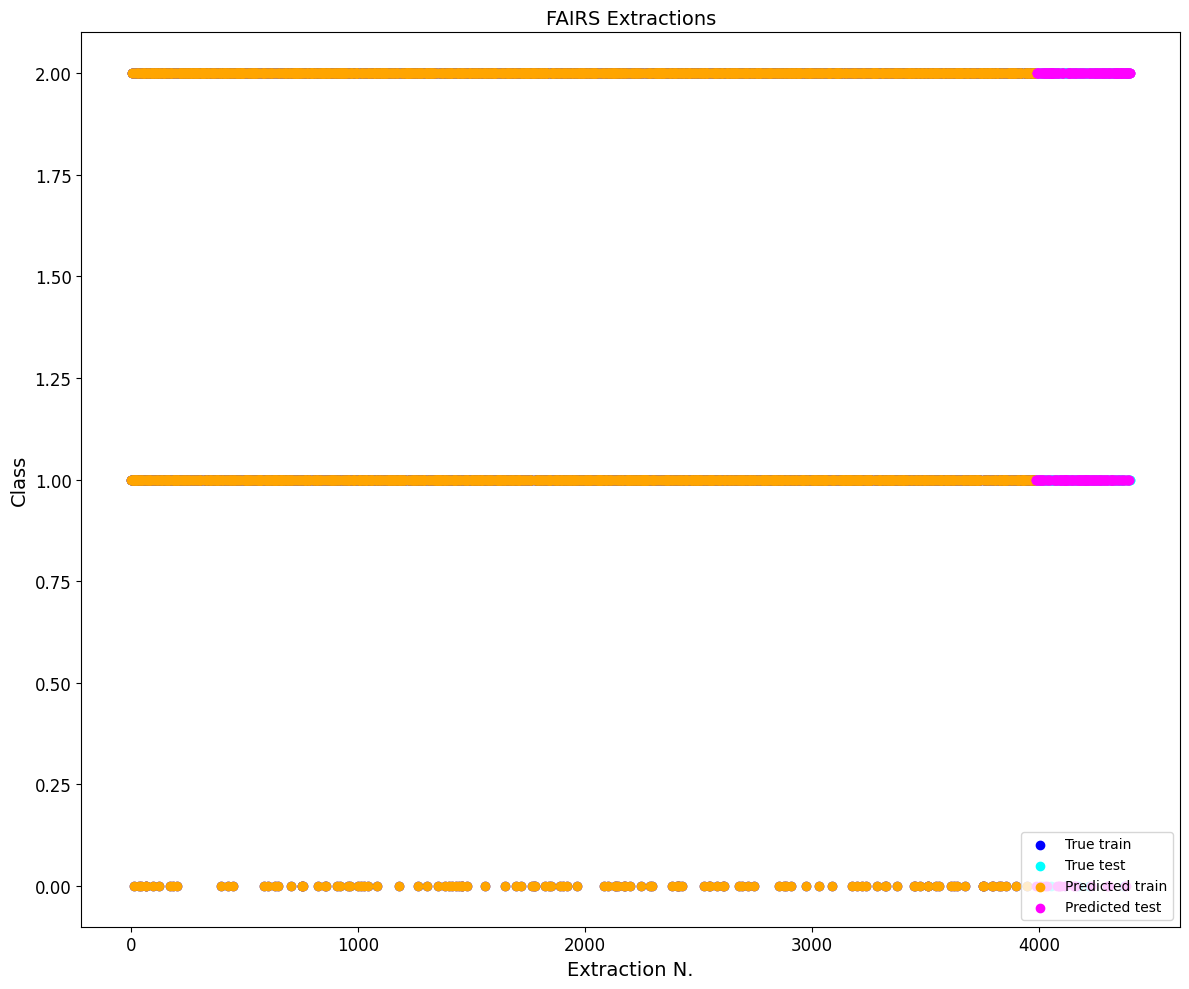

In [5]:
values = {'train' : [train_idx, Y_train.tolist(), train_predictions.tolist()], 
          'test' : [test_idx, Y_test.tolist(), test_predictions.tolist()]}
validator.plot_timeseries_prediction(values, 'decision_tree_predictions', res_path)

### 1.2 FAIRS pretrained models

In [6]:
validator = ModelValidation()

# create subfolder for evaluation data
eval_path = os.path.join(model_folder, 'evaluation') 
os.mkdir(eval_path) if not os.path.exists(eval_path) else None

# predict lables from train set
predicted_train = model.predict(train_inputs, verbose=0)
y_pred = np.argmax(predicted_train, axis=-1)
y_true = np.argmax(train_outputs, axis=-1)

# show predicted classes (train dataset)
class_pred, class_true = np.unique(y_pred), np.unique(y_true)
print(f'\nNumber of classes observed in train (true labels): {len(class_true)}')
print(f'Number of classes observed in train (predicted labels): {len(class_pred)}')
print(f'Classes observed in predicted train labels:\n{class_pred}')

# predict labels from test set
predicted_test = model.predict(test_inputs, verbose=0)
y_pred_labels = np.argmax(predicted_test, axis=-1)
y_true_labels = np.argmax(test_outputs, axis=-1)

# show predicted classes (test dataset)
class_pred, class_true = np.unique(y_pred), np.unique(y_true)
print(f'\nNumber of classes observed in test (true labels): {len(class_true)}')
print(f'Number of classes observed in test (predicted labels): {len(class_pred)}')
print(f'Classes observed in predicted test labels:\n{class_pred}')


Number of classes observed in train (true labels): 3
Number of classes observed in train (predicted labels): 3
Classes observed in predicted train labels:
[0 1 2]

Number of classes observed in test (true labels): 3
Number of classes observed in test (predicted labels): 3
Classes observed in predicted test labels:
[0 1 2]


### 2. Confusion matrix

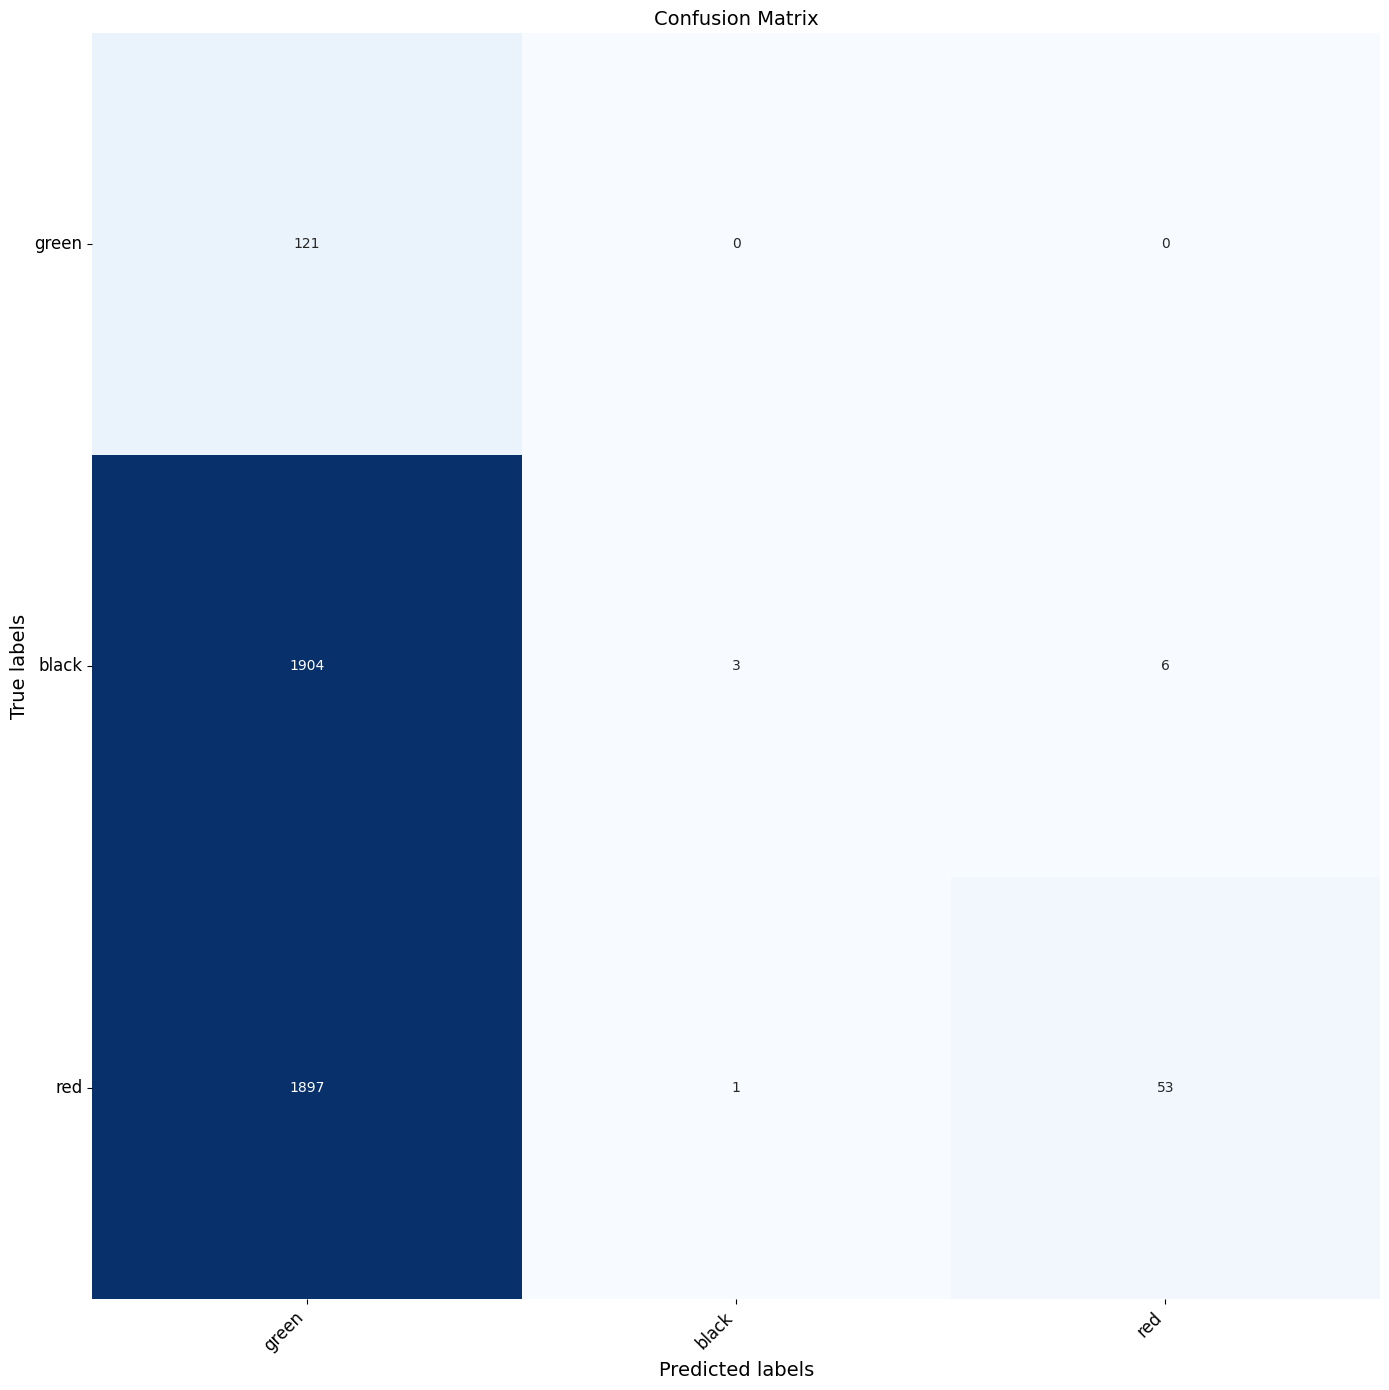

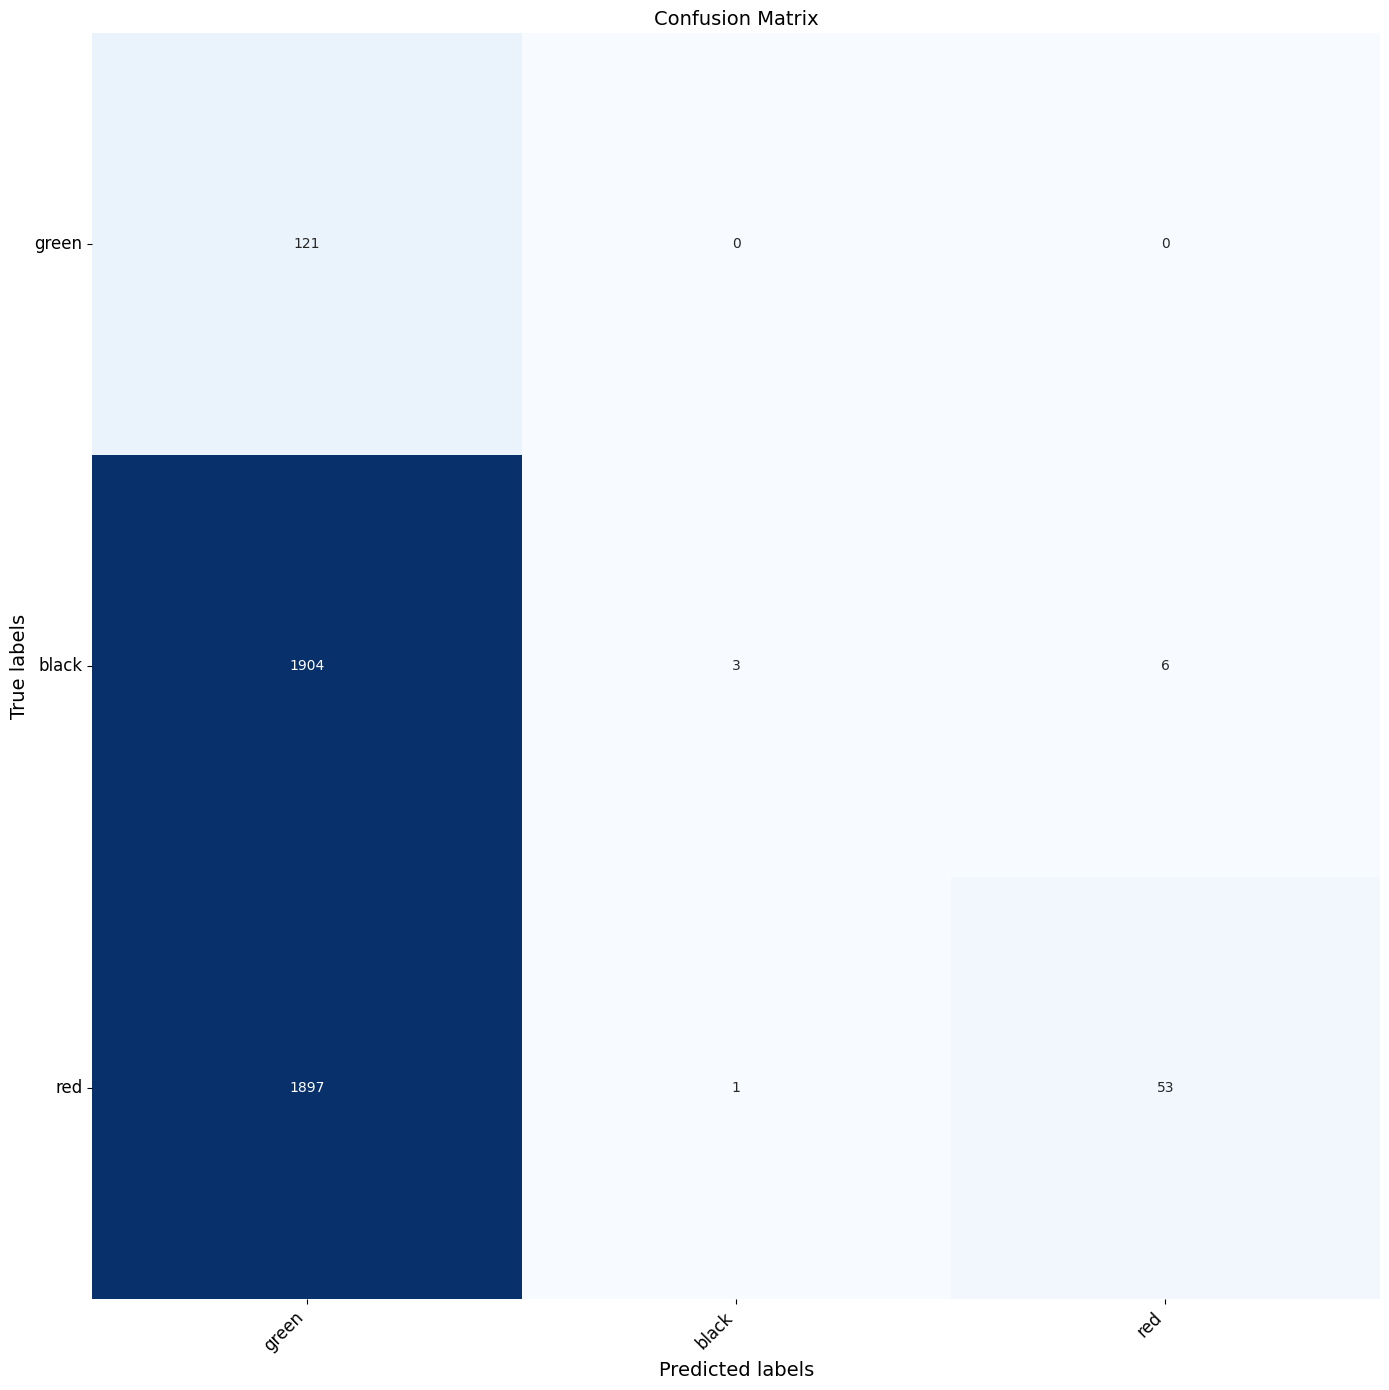

In [7]:
# generate confusion matrix from train set (if class num is equal)
validator.plot_confusion_matrix(y_true, y_pred, 'confusion_matrix_train', eval_path)    
validator.plot_confusion_matrix(y_true, y_pred, 'confusion_matrix_test', eval_path)   